# 1. Préparer les données

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
df = pd.read_csv("data/data.csv", header=0)

## Prérequis pour la corrélation de Pearson

- ✅ L’échantillon de données est aléatoire
(représentatif de la population):
    - On estime que l’échantillon de 537 élèves est suffisamment représentatif de la population des élèves âgés de 8 à 14 ans.
- ✅ Les variables sont quantitatives (continues):
    - Temps d'écran moyen quotidien (en heures)
    - Moyenne générale (sur 100)
- ✅ Les données sont associées par paires (on associe à chaque valeur x, une valeur y)
    - Chaque élève a une valeur pour le temps d'écran et une valeur pour la moyenne générale.
- ✅ Les observations sont indépendantes:
    - Les réponses des élèves sont indépendantes les unes des autres.
- ❔Les données sont distribuées normalement:
    - À vérifier avec un test de normalité (ex: test de Shapiro-Wilk)
- ❔Il existe une relation linéaire entre les variables:
    - À vérifier avec un nuage de points (scatter plot)
- ❔Aucun outlier n’est présent dans les données:
    - À vérifier avec un boxplot ou en calculant les z-scores

In [3]:
col_academic_performance = "AcademicPerformanceLastorCurrentAcademicYear"
col_screen_time = "ScreentimeHoursDayMobileTablet"

### Test de normalité des données

Text(0.5, 1.0, "Distribution du temps d'écran")

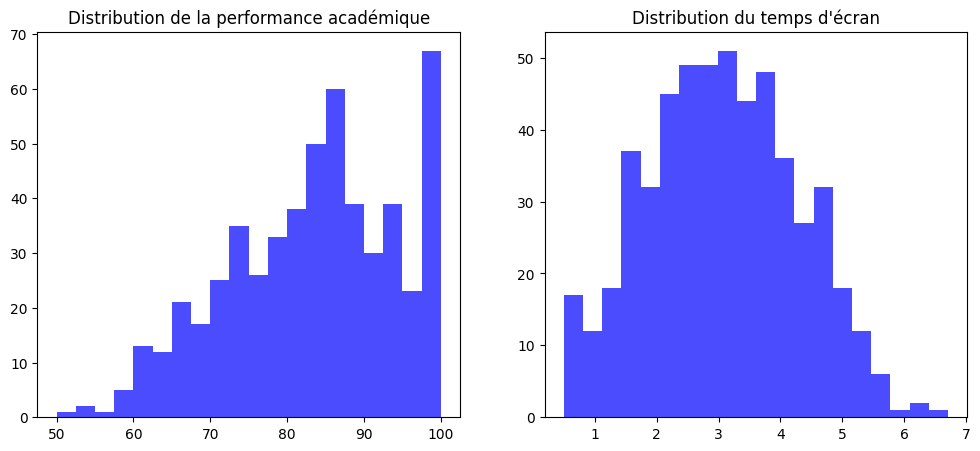

In [4]:
# Visualisation de la distribution des données (performance académique et temps d'écran)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df[col_academic_performance].dropna(), bins=20, color='blue', alpha=0.7)
plt.title('Distribution de la performance académique')
plt.subplot(1, 2, 2)
plt.hist(df[col_screen_time].dropna(), bins=20, color='blue', alpha=0.7)
plt.title('Distribution du temps d\'écran')

On constate que les données sont right-skewed (asymétrie positive) pour la performance académique, et left-skewed (asymétrie négative) pour le temps d'écran.

On excluera aussi les valeurs du top 1% des élèves ayant une note très élevée car elles pourraient biaiser les résultats.

On va donc corriger cette asymétrie avant de procéder au test de corrélation de Pearson, en calculant la racine cubique des valeurs de la performance académique, et en mettant au carré les valeurs du temps d'écran.

In [5]:
# normalize data right after
academic_performance = (df[col_academic_performance] - df[col_academic_performance].mean()) / df[col_academic_performance].std()
screen_time = (df[col_screen_time] - df[col_screen_time].mean()) / df[col_screen_time].std()

In [6]:
# We remove students whose academic performance is in the top x%
top_percentile = 0.05
upper_threshold = academic_performance.quantile(1 - top_percentile)
lower_threshold = academic_performance.quantile(top_percentile)
mask = (academic_performance < upper_threshold) & (academic_performance > lower_threshold)
academic_performance = academic_performance[mask]
screen_time = screen_time[mask]

print(f"Removed {len(df) - len(academic_performance)} students in the top {top_percentile*100}% of academic performance.")

Removed 72 students in the top 5.0% of academic performance.


In [7]:
import numpy as np

In [8]:
academic_performance_corrected = academic_performance.dropna()
screen_time_corrected = (screen_time.dropna() ** (1/2)).dropna()

Text(0.5, 1.0, "Distribution du temps d'écran")

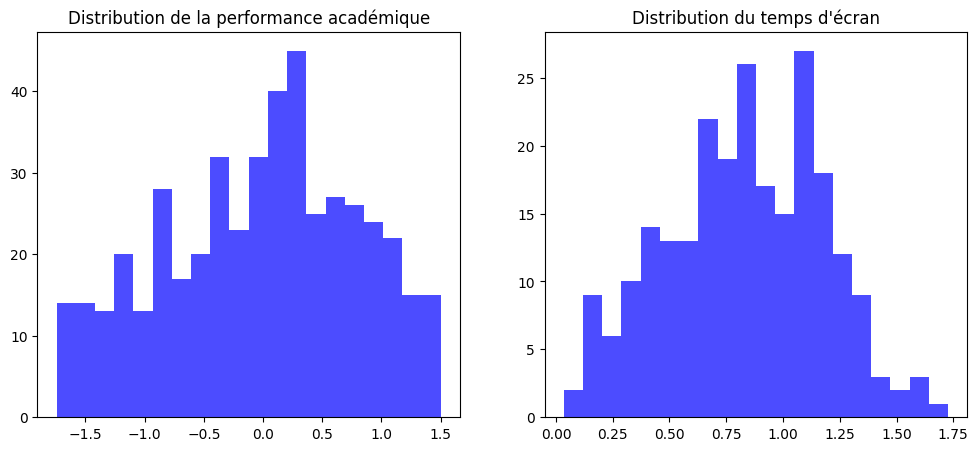

In [9]:
# Visualisation de la distribution des données
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(academic_performance_corrected, bins=20, color='blue', alpha=0.7)
plt.title('Distribution de la performance académique')
plt.subplot(1, 2, 2)
plt.hist(screen_time_corrected, bins=20, color='blue', alpha=0.7)
plt.title('Distribution du temps d\'écran')

In [10]:
# Test de normalité de Shapiro-Wilk
shapiro_academic = stats.shapiro(academic_performance_corrected)
shapiro_screen_time = stats.shapiro(screen_time_corrected)

print(f"Test de Shapiro-Wilk pour la performance académique : \n{shapiro_academic.statistic}, p-value={shapiro_academic.pvalue}")
print(f"Test de Shapiro-Wilk pour le temps d'écran : \n{shapiro_screen_time.statistic}, p-value={shapiro_screen_time.pvalue}")

Test de Shapiro-Wilk pour la performance académique : 
0.9769774434092612, p-value=1.027034366127456e-06
Test de Shapiro-Wilk pour le temps d'écran : 
0.9902496190657095, p-value=0.10582478806106033


Voici les résultats des tests de normalité de Shapiro-Wilk pour les deux variables :

On constate que la p-value pour la performance académique est inférieure à 0.05 mais pas pour le temps d'écran. Donc, l'hypothèse de normalité n'est pas satisfaite pour la performance académique, mais elle l'est pour le temps d'écran.

On peut tout de même procéder au test de corrélation de Pearson, en gardant à l'esprit que la normalité n'est pas parfaitement respectée pour la performance académique.

On pose les hypothèses suivantes :
- H0 : Il n'y a pas de corrélation entre le temps d'écran et la performance académique.
- H1 : Il y a une corrélation entre le temps d'écran et la performance académique.

## Le test de Pearson
Pour vérifier si le coefficient de Pearson est significatif, on peut faire un test t.

Ce test t demande les variables suivantes :
- n : taille de l'échantillon
- r : coefficient de Pearson

On utilise la formule suivante pour calculer la statistique t :

$ t = \frac{r \sqrt{n - 2}}{\sqrt{1 - r^2}} $

Ici, on a :


In [11]:
r = academic_performance_corrected.corr(screen_time_corrected, method='pearson')
print(f"Coefficient de corrélation de Pearson entre la performance académique et le temps d'écran\nr = {r}")

Coefficient de corrélation de Pearson entre la performance académique et le temps d'écran
r = -0.2476026884433667


In [12]:
n = len(df)
t = r * (n - 2) ** 0.5 / ((1 - r ** 2) ** 0.5)
print(f"Statistique t : {t}")

Statistique t : -5.9111295612253585


À partir de ce t, on peut calculer la p-value associée.

On fait un test bilatéral, c'est-à-dire qu'on regarde si la corrélation est significativement différente de zéro, qu'elle soit positive ou négative.

Le test bilatéral expliqué, c'est qu'on calcule la probabilité que la statistique t soit aussi extrême que celle observée, dans les deux directions (positive et négative).

Pour cela, on calcule `stats.t.cdf(abs(t), df=n-2)` pour obtenir la probabilité que la statistique t soit inférieure à la valeur absolue de t. Le `df=n-2` correspond aux degrés de liberté du test t, où n est la taille de l'échantillon. On fait `-2` parce qu'on estime deux paramètres (la moyenne et l'écart-type) à partir des données.

Ensuite, on fait `1 - stats.t.cdf(...)` pour obtenir la probabilité que la statistique t soit supérieure à la valeur absolue de t.

Enfin, on multiplie par 2 pour obtenir la p-value bilatérale.

Donc $$p\text{-value} = 2 \cdot P(T > |t|) = 2 \cdot [1 - F_T(|t|; n-2)]$$

où $F_T$ est la fonction de répartition (CDF) de la distribution t de Student à $n-2$ degrés de liberté.


In [14]:
# Let's use this t value to get a p-value
p_value = 2 * (1 - stats.t.cdf(abs(t), df=n-2))
print(f"P-value associée : {p_value}")

P-value associée : 6.056811496790715e-09


La p-value associée est 5.25e-08, ce qui est bien inférieur au seuil de 0.05.

Sous l'hypothèse nulle $H_0: \rho = 0$, la statistique $t = \frac{r\sqrt{n-2}}{\sqrt{1-r^2}}$ suit une distribution $t_{n-2}$. Le facteur 2 provient de la nature bilatérale du test ($H_1: \rho \neq 0$), permettant de rejeter $H_0$ pour des corrélations significativement positives ou négatives.